# BN Generation Parameter Sweep

This notebook sweeps over DAG/BN generation parameters outlined in `notebooks/graph_generation/ideas.md` and materializes multiple discrete BN variants per DAG.

It varies:
- n (number of variables)
- target treewidth
- variable arity (fixed or range)
- CPT skewness (Dirichlet alpha)
- determinism fraction (mostly 0%)

Outputs:
- CSV with per-variant metadata
- On-screen CPT previews for a small sample



In [1]:
import sys
from pathlib import Path
import re
from os import getenv

# Ensure src is importable
repo_root = Path(".").resolve().parents[1]
sys.path.append(str(repo_root / 'src'))

from graph_generation import generate_dag_with_treewidth
from bn_generation import generate_variants_for_dag
from cpd_utils import cpd_to_ascii_table
from discrete.discrete_inference import format_probability_query, query_probability
from llm_calling import run_llm_call
from yaml_utils import load_yaml

import pandas as pd
import numpy as np
from openai import OpenAI

In [2]:
# LLM Configuration and Helper Functions
MODEL = "openai/o3-mini-high"  # Change this to your preferred model
MODEL = "deepseek/deepseek-chat-v3.1:free"

# Initialize OpenAI client
client = OpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key=getenv("OPENROUTER_API_KEY")
)

# Load prompts
prompt_path = repo_root / "notebooks" / "discrete" / "prompts.yaml"
prompts = load_yaml(prompt_path)
# Import the functions from llm_calling instead of defining them here
from llm_calling import extract_numeric_answer, create_probability_prompt, run_llm_call 


In [3]:
# Parameter grids (edit as needed)
#ns = [7, 11, 15]
ns = [10]
#treewidths = [2, 3, 4]
treewidths = [3]
arity_specs = [
    #{"type": "fixed", "fixed": 2},
    {"type": "range", "min": 2, "max": 3},
]
#dirichlet_alphas = [0.5, 1.0]
dirichlet_alphas = [1.0]
#determinism_fracs = [0.0, 0.1]  # mostly 0%; includes a nonzero test
determinism_fracs = [0.0]  # mostly 0%; includes a nonzero test
#naming_strategies = ['simple', 'confusing', 'semantic']  # Add naming strategy variation
naming_strategies = ['simple', 'confusing']  # Add naming strategy variation
variants_per_combo = 2
base_seed = 42

rows = []
preview_samples = []

In [4]:
def arity_to_str(spec):
    if spec["type"] == "fixed":
        return f"fixed:{spec['fixed']}"
    return f"range:{spec['min']}-{spec['max']}"

sample_counter = 0
all_bayesian_networks = []  # Store all BNs and their metadata

for n in ns:
    for tw in treewidths:
        for naming in naming_strategies:
            dag, achieved_tw, _ = generate_dag_with_treewidth(n, tw, node_naming=naming, seed=base_seed + sample_counter)
            for arity in arity_specs:
                for alpha in dirichlet_alphas:
                    for det in determinism_fracs:
                        cfgs = []
                        for i in range(variants_per_combo):
                            cfgs.append({
                                "arity_strategy": arity,
                                "dirichlet_alpha": alpha,
                                "determinism_fraction": det,
                            })
                        variants = generate_variants_for_dag(dag, cfgs, base_seed=base_seed + sample_counter)
                        for idx, (bn, meta) in enumerate(variants):
                            # Store BN and its metadata for later access
                            all_bayesian_networks.append({
                                "bn": bn,
                                "meta": {
                                    "n": n,
                                    "target_tw": tw,
                                    "achieved_tw": achieved_tw,
                                    "naming": naming,
                                    "arity": arity_to_str(arity),
                                    "alpha": meta["dirichlet_alpha"],
                                    "determinism": meta["determinism_fraction"],
                                    "seed": meta["seed"],
                                    "variant_index": idx,
                                    "num_edges": bn.number_of_edges(),
                                    "num_nodes": bn.number_of_nodes(),
                                }
                            })
                            rows.append({
                                "n": n,
                                "target_tw": tw,
                                "achieved_tw": achieved_tw,
                                "naming": naming,
                                "arity": arity_to_str(arity),
                                "alpha": meta["dirichlet_alpha"],
                                "determinism": meta["determinism_fraction"],
                                "seed": meta["seed"],
                                "variant_index": idx,
                                "num_edges": bn.number_of_edges(),
                                "num_nodes": bn.number_of_nodes(),
                            })
                            if sample_counter < 3:  # collect a few previews
                                preview_samples.append(bn)
                        sample_counter += 1



In [5]:
df = pd.DataFrame(rows)
display(df.head())
print(f"Total variants: {len(df)}")

# Save CSV next to notebook
out_csv = repo_root / 'notebooks' / 'graph_generation' / 'bn_generation_sweep.csv'
df.to_csv(out_csv, index=False)
print('Saved to', out_csv)

,n,target_tw,achieved_tw,naming,arity,alpha,determinism,seed,variant_index,num_edges,num_nodes
0,10,3,3,simple,range:2-3,1.0,0.0,42,0,15,10
1,10,3,3,simple,range:2-3,1.0,0.0,10015,1,15,10
2,10,3,3,confusing,range:2-3,1.0,0.0,43,0,13,10
3,10,3,3,confusing,range:2-3,1.0,0.0,10016,1,13,10


Total variants: 4
Saved to /home/bmihaljevic/repos/code-projects/aily/probabilistic-reasoning-llms/notebooks/graph_generation/bn_generation_sweep.csv


In [9]:
# For each Bayesian network, generate n queries using generate_queries, run them, and collect results
from query_generation import generate_queries
from pgmpy.inference import VariableElimination

# Store all queries for later recovery: a list of lists (per BN)
all_bn_queries = []

query_rows = []

for idx, bn_dict in enumerate(all_bayesian_networks):
    bn = bn_dict["bn"]
    # Use a different seed per BN for query generation for reproducibility
    query_seed = 1000 + idx
    # Generate 5 queries for this BN
    queries = generate_queries(
        bn,
        num_queries=24,
        #query_node_counts=(1, 2),
        query_node_counts=[1],
        evidence_counts=(0, 1, 2),
        #distance_buckets=[(1, 1), (2, 3), (1, 3)],
        distance_buckets=[(2, 3)],
        seed=query_seed,
    )
    all_bn_queries.append(queries)
    # Get the BN's properties from the main df
    bn_row = df.iloc[idx].to_dict()
    for qidx, query in enumerate(queries):
        # Prepare inference
        infer = VariableElimination(bn)
        # Query variables and their states
        query_vars = [v for v, _ in query.targets]
        query_states = [s for _, s in query.targets]
        # Evidence dict: variable -> state
        evidence = query.evidence if query.evidence else None

        # Compute exact probability
        try:
            # pgmpy: query returns a factor, we need to index into the right assignment
            result = infer.query(variables=query_vars, evidence=evidence, show_progress=False)
            # result is a DiscreteFactor, get the probability for the assignment
            # The order of query_vars matches the order of query_states
            assignment = dict(zip(query_vars, query_states))
            prob = result.get_value(**assignment)
        except Exception as e:
            prob = None

        # Collect all info for the table, merging BN and query properties (no LLM here)
        row = dict(bn_row)  # copy BN properties
        row.update({
            "bn_index": idx,
            "query_index": qidx,
            "query_vars": str(query_vars),
            "query_states": str(query_states),
            "evidence": str(query.evidence),
            "distance": query.meta.get("min_target_evidence_distance"),
            "num_evidence": query.meta.get("num_evidence_nodes"),
            "probability": prob,
        })
        query_rows.append(row)

# Convert to DataFrame and display
full_df = pd.DataFrame(query_rows)
print(f"Total queries: {len(full_df)}")



# Optionally, save the full query+BN dataframe
out_query_csv = repo_root / 'notebooks' / 'graph_generation' / 'bn_generation_sweep_queries.csv'
full_df.to_csv(out_query_csv, index=False)
print('Saved query+BN results to', out_query_csv)



NameError: name 'QuerySpec' is not defined

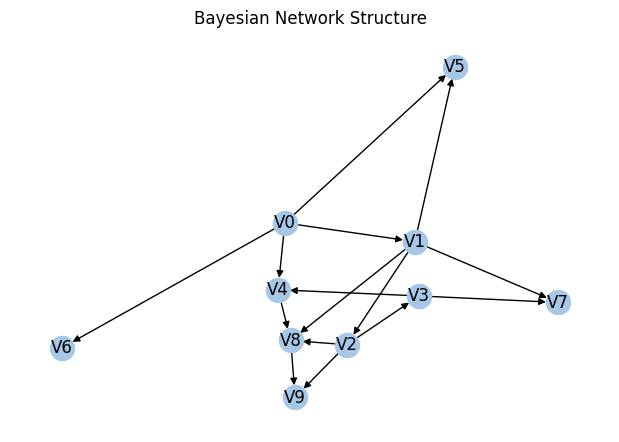

Query: P(V3=s2 | V8=s0, V9=s0)
Exact probability: 0.7026418656199114

SYSTEM PROMPT:
You are an assistant that helps with probability reasoning calculations. You will be given some conditional probability tables (CPTs) and a query.

## CPT Format Guide

### 1. Marginal CPTs (nodes with no parents)
```
+----------------+------------+
| Node(Value)    | Probability|
+----------------+------------+
| A(yes)         | 0.3        |
+----------------+------------+
| A(no)          | 0.7        |
+----------------+------------+
```
Each row means **P(Node=Value) = Probability**.

### 2. Conditional CPTs (nodes with one or more parents)
- The **first rows** list all parent nodes
- Each **column** represents one combination of parent values
- **Child rows** give P(child=value | parent assignment) for that column
- Probabilities in each column **sum to 1**

**Example:**
```
+----------+----------+----------+----------+----------+
| A        | A(yes)   | A(yes)   | A(no)    | A(no)    |
+--------

INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


LLM probability: 0.5149
Absolute error: 0.18774186561991135
{'query': 'P(V3=s2 | V8=s0, V9=s0)', 'exact_probability': 0.7026418656199114, 'llm_probability': 0.5149, 'delta': 0.18774186561991135, 'llm_response': 'Final Answer: P(V3=s2 | V8=s0, V9=s0) = 0.5149'}


In [ ]:
# Inspect a single row: draw BN, call LLM, compare\n
from bn_query_sweep import inspect_row_and_call_llm, call_llm_for_query
from pathlib import Path

# Choose a row index from full_df
#row_index = 330
row_index = 33

result = inspect_row_and_call_llm(
    full_df=full_df,
    all_bayesian_networks=all_bayesian_networks,
    row_index=row_index,
    openai_client=client,
    model=MODEL,
    prompts_path=prompt_path,
    draw_kwargs={"figsize": (6, 4)},
)
print(result)

In [ ]:
# Optional: Call LLM on a subset AFTER query generation
# Provide indices of rows in full_df for which to call the LLM.
# Import _parse_field from bn_query_sweep instead of defining it locally
from bn_query_sweep import _parse_field

# Ensure LLM columns exist
if 'llm_probability' not in full_df.columns:
    full_df['llm_probability'] = None
if 'llm_response' not in full_df.columns:
    full_df['llm_response'] = None

# Select which rows to send to LLM (example below commented out)
selected_indices = list(full_df.sample(n=40, random_state=0).index)

for ridx in selected_indices:
    row = full_df.iloc[ridx]
    bn = all_bayesian_networks[int(row['bn_index'])]['bn']
    query_vars = _parse_field(row['query_vars']) or []
    query_states = _parse_field(row['query_states']) or []
    evidence = _parse_field(row['evidence']) or None
    print(f"Processing BN {int(row['bn_index'])}/{len(all_bayesian_networks)}, Query {int(row['query_index'])}...")
    llm_prob, llm_response = call_llm_for_query(bn, query_vars, query_states, evidence)
    full_df.at[ridx, 'llm_probability'] = llm_prob
    full_df.at[ridx, 'llm_response'] = llm_response

Processing BN 1/4, Query 2...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Processing BN 3/4, Query 12...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.495181 seconds
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.825944 seconds
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Processing BN 0/4, Query 2...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Processing BN 2/4, Query 7...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Processing BN 2/4, Query 20...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Processing BN 3/4, Query 9...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.482008 seconds
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Processing BN 0/4, Query 16...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.442183 seconds
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Processing BN 3/4, Query 6...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Processing BN 2/4, Query 6...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Processing BN 2/4, Query 18...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.416044 seconds
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Processing BN 2/4, Query 5...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Processing BN 3/4, Query 16...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.400881 seconds
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Processing BN 2/4, Query 23...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.443351 seconds
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.875432 seconds
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 429 Too Many Requests"


Error calling LLM: Error code: 429 - {'error': {'message': 'Rate limit exceeded: free-models-per-min. ', 'code': 429, 'metadata': {'headers': {'X-RateLimit-Limit': '16', 'X-RateLimit-Remaining': '0', 'X-RateLimit-Reset': '1757685240000'}, 'provider_name': None}}, 'user_id': 'user_31uN93ELbm4XDhjPuC6JxTwJXET'}
Processing BN 0/4, Query 13...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.497605 seconds
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.891903 seconds
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.453453 seconds


Error calling LLM: Error code: 429 - {'error': {'message': 'Rate limit exceeded: free-models-per-min. ', 'code': 429, 'metadata': {'headers': {'X-RateLimit-Limit': '16', 'X-RateLimit-Remaining': '0', 'X-RateLimit-Reset': '1757685240000'}, 'provider_name': None}}, 'user_id': 'user_31uN93ELbm4XDhjPuC6JxTwJXET'}
Processing BN 0/4, Query 7...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.786928 seconds
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 429 Too Many Requests"


Error calling LLM: Error code: 429 - {'error': {'message': 'Rate limit exceeded: free-models-per-min. ', 'code': 429, 'metadata': {'headers': {'X-RateLimit-Limit': '16', 'X-RateLimit-Remaining': '0', 'X-RateLimit-Reset': '1757685240000'}, 'provider_name': None}}, 'user_id': 'user_31uN93ELbm4XDhjPuC6JxTwJXET'}
Processing BN 1/4, Query 6...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.431627 seconds
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.811171 seconds
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.445741 seconds


Error calling LLM: Error code: 429 - {'error': {'message': 'Rate limit exceeded: free-models-per-min. ', 'code': 429, 'metadata': {'headers': {'X-RateLimit-Limit': '16', 'X-RateLimit-Remaining': '0', 'X-RateLimit-Reset': '1757685240000'}, 'provider_name': None}}, 'user_id': 'user_31uN93ELbm4XDhjPuC6JxTwJXET'}
Processing BN 0/4, Query 22...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.955953 seconds
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 429 Too Many Requests"


Error calling LLM: Error code: 429 - {'error': {'message': 'Rate limit exceeded: free-models-per-min. ', 'code': 429, 'metadata': {'headers': {'X-RateLimit-Limit': '16', 'X-RateLimit-Remaining': '0', 'X-RateLimit-Reset': '1757685240000'}, 'provider_name': None}}, 'user_id': 'user_31uN93ELbm4XDhjPuC6JxTwJXET'}
Processing BN 1/4, Query 0...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.393641 seconds
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.794945 seconds
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 429 Too Many Requests"


Error calling LLM: Error code: 429 - {'error': {'message': 'Rate limit exceeded: free-models-per-min. ', 'code': 429, 'metadata': {'headers': {'X-RateLimit-Limit': '16', 'X-RateLimit-Remaining': '0', 'X-RateLimit-Reset': '1757685240000'}, 'provider_name': None}}, 'user_id': 'user_31uN93ELbm4XDhjPuC6JxTwJXET'}
Processing BN 1/4, Query 9...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.453018 seconds
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.976064 seconds
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 429 Too Many Requests"


Error calling LLM: Error code: 429 - {'error': {'message': 'Rate limit exceeded: free-models-per-min. ', 'code': 429, 'metadata': {'headers': {'X-RateLimit-Limit': '16', 'X-RateLimit-Remaining': '0', 'X-RateLimit-Reset': '1757685240000'}, 'provider_name': None}}, 'user_id': 'user_31uN93ELbm4XDhjPuC6JxTwJXET'}
Processing BN 0/4, Query 8...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.435946 seconds
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.876006 seconds
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.403462 seconds


Error calling LLM: Error code: 429 - {'error': {'message': 'Rate limit exceeded: free-models-per-min. ', 'code': 429, 'metadata': {'headers': {'X-RateLimit-Limit': '16', 'X-RateLimit-Remaining': '0', 'X-RateLimit-Reset': '1757685240000'}, 'provider_name': None}}, 'user_id': 'user_31uN93ELbm4XDhjPuC6JxTwJXET'}
Processing BN 1/4, Query 19...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.850696 seconds
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 429 Too Many Requests"


Error calling LLM: Error code: 429 - {'error': {'message': 'Rate limit exceeded: free-models-per-min. ', 'code': 429, 'metadata': {'headers': {'X-RateLimit-Limit': '16', 'X-RateLimit-Remaining': '0', 'X-RateLimit-Reset': '1757685240000'}, 'provider_name': None}}, 'user_id': 'user_31uN93ELbm4XDhjPuC6JxTwJXET'}
Processing BN 2/4, Query 14...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.436665 seconds
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.856210 seconds
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 429 Too Many Requests"


Error calling LLM: Error code: 429 - {'error': {'message': 'Rate limit exceeded: free-models-per-min. ', 'code': 429, 'metadata': {'headers': {'X-RateLimit-Limit': '16', 'X-RateLimit-Remaining': '0', 'X-RateLimit-Reset': '1757685300000'}, 'provider_name': None}}, 'user_id': 'user_31uN93ELbm4XDhjPuC6JxTwJXET'}
Processing BN 0/4, Query 3...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.452884 seconds
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.987770 seconds
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Processing BN 3/4, Query 14...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.492349 seconds
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.764524 seconds
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 429 Too Many Requests"


Error calling LLM: Error code: 429 - {'error': {'message': 'Provider returned error', 'code': 429, 'metadata': {'raw': 'deepseek/deepseek-chat-v3.1:free is temporarily rate-limited upstream. Please retry shortly, or add your own key to accumulate your rate limits: https://openrouter.ai/settings/integrations', 'provider_name': 'DeepInfra'}}, 'user_id': 'user_31uN93ELbm4XDhjPuC6JxTwJXET'}
Processing BN 1/4, Query 21...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.395113 seconds
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Processing BN 2/4, Query 0...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Processing BN 0/4, Query 6...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Processing BN 3/4, Query 23...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Processing BN 3/4, Query 8...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Processing BN 3/4, Query 3...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Processing BN 2/4, Query 12...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Processing BN 3/4, Query 7...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Processing BN 3/4, Query 13...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Processing BN 3/4, Query 19...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Processing BN 2/4, Query 3...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:openai._base_client:Retrying request to /chat/completions in 0.462980 seconds
INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Processing BN 1/4, Query 3...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Processing BN 0/4, Query 18...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Processing BN 2/4, Query 8...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Processing BN 2/4, Query 15...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


Processing BN 3/4, Query 1...


INFO:httpx:HTTP Request: POST https://openrouter.ai/api/v1/chat/completions "HTTP/1.1 200 OK"


In [8]:
out_llm_csv = out_query_csv.with_name(out_query_csv.stem + "_with_llm.csv")
# Save the DataFrame with LLM responses to a CSV file
#out_llm_csv = out_query_csv.replace(".csv", "_with_llm.csv")
full_df.to_csv(out_llm_csv, index=False)
print("Saved DataFrame with LLM responses to", out_llm_csv)

NameError: name 'out_query_csv' is not defined

In [ ]:
# Print rows with non-empty llm_probability
llm_rows = full_df[full_df['llm_probability'].notna()]
print(f"Found {len(llm_rows)} rows with LLM probability values:")
print("=" * 80)
display(llm_rows)


Found 29 rows with LLM probability values:


,n,target_tw,achieved_tw,naming,arity,alpha,determinism,seed,variant_index,num_edges,...,bn_index,query_index,query_vars,query_states,evidence,distance,num_evidence,probability,llm_probability,llm_response
2,10,3,3,simple,range:2-3,1.0,0.0,42,0,15,...,0,2,[np.str_('V3')],['s2'],{},0,0,0.255518,0.2409,Final Answer: P(V3=s2) = 0.2409
3,10,3,3,simple,range:2-3,1.0,0.0,42,0,15,...,0,3,[np.str_('V7')],['s0'],{},0,0,0.555743,0.5043,"To compute \( P(V7 = s0) \), we need to margin..."
6,10,3,3,simple,range:2-3,1.0,0.0,42,0,15,...,0,6,[np.str_('V4')],['s0'],{},0,0,0.301734,0.3241,Final Answer: P(V4=s0) = 0.3241
16,10,3,3,simple,range:2-3,1.0,0.0,42,0,15,...,0,16,[np.str_('V7')],['s1'],"{np.str_('V9'): 's2', np.str_('V8'): 's0'}",2,2,0.463258,0.4645,"Final Answer: P(V7=s1 | V9=s2, V8=s0) = 0.4645"
18,10,3,3,simple,range:2-3,1.0,0.0,42,0,15,...,0,18,[np.str_('V6')],['s1'],"{np.str_('V5'): 's1', np.str_('V8'): 's1'}",2,2,0.164632,0.0343,"Final Answer: P(V6=s1 | V5=s1, V8=s1) = 0.0343"
26,10,3,3,simple,range:2-3,1.0,0.0,10015,1,15,...,1,2,[np.str_('V0')],['s0'],{},0,0,0.801712,0.8017,Final Answer: P(V0=s0) = 0.8017
27,10,3,3,simple,range:2-3,1.0,0.0,10015,1,15,...,1,3,[np.str_('V9')],['s1'],{},0,0,0.485145,0.5487,Final Answer: P(V9=s1) = 0.5487
45,10,3,3,simple,range:2-3,1.0,0.0,10015,1,15,...,1,21,[np.str_('V6')],['s0'],{np.str_('V2'): 's1'},3,1,0.443665,0.4506,Final Answer: P(V6=s0 | V2=s1) = 0.4506
48,10,3,3,confusing,range:2-3,1.0,0.0,43,0,13,...,2,0,[np.str_('Q_0vvk1h')],['s0'],{np.str_('M_o25r7f'): 's2'},2,1,0.847834,0.6374,Final Answer: P(Q_0vvk1h=s0 | M_o25r7f=s2) = 0...
51,10,3,3,confusing,range:2-3,1.0,0.0,43,0,13,...,2,3,[np.str_('Q_0vvk1h')],['s1'],"{np.str_('B_8lc9em'): 's0', np.str_('Y_6kj8e2'...",2,2,0.149168,0.0037,"Final Answer: P(Q_0vvk1h=s1 | B_8lc9em=s0, Y_6..."


In [ ]:
# Display LLM performance statistics
print("LLM Performance Analysis:")
print("=" * 50)

# Count successful LLM responses
successful_llm = full_df['llm_probability'].notna().sum()
total_queries = len(full_df)
print(f"Successful LLM responses: {successful_llm}/{total_queries} ({successful_llm/total_queries*100:.1f}%)")

# Save enhanced results with LLM data
enhanced_csv = repo_root / 'notebooks' / 'graph_generation' / 'bn_generation_sweep_queries_with_llm.csv'
full_df.to_csv(enhanced_csv, index=False)
print(f'Saved enhanced results with LLM data to {enhanced_csv}')

LLM Performance Analysis:
Successful LLM responses: 29/96 (30.2%)
Saved enhanced results with LLM data to /home/bmihaljevic/repos/code-projects/aily/probabilistic-reasoning-llms/notebooks/graph_generation/bn_generation_sweep_queries_with_llm.csv


In [ ]:
# Calculate accuracy metrics for successful responses
if successful_llm > 0:
    # Filter to only successful LLM responses
    successful_df = full_df[full_df['llm_probability'].notna() & full_df['probability'].notna()]
    
    if len(successful_df) > 0:
        # Calculate absolute errors
        successful_df = successful_df.copy()
        successful_df['abs_error'] = abs(successful_df['llm_probability'] - successful_df['probability'])
        successful_df['rel_error'] = successful_df['abs_error'] / successful_df['probability']
        
        print(f"\nAccuracy Metrics (for {len(successful_df)} successful responses):")
        print(f"Mean Absolute Error: {successful_df['abs_error'].mean():.6f}")
        print(f"Mean Relative Error: {successful_df['rel_error'].mean():.6f}")
        print(f"Max Absolute Error: {successful_df['abs_error'].max():.6f}")
        print(f"Max Relative Error: {successful_df['rel_error'].max():.6f}")
        
        # Show some examples
        print(f"\nFirst 5 successful responses:")
        display(successful_df[['query_vars', 'query_states', 'evidence', 'probability', 'llm_probability', 'abs_error']].head())
    else:
        print("No successful LLM responses with exact inference results to compare.")
else:
    print("No successful LLM responses.")


Accuracy Metrics (for 29 successful responses):
Mean Absolute Error: 0.066027
Mean Relative Error: 0.221639
Max Absolute Error: 0.227203
Max Relative Error: 0.975196

First 5 successful responses:


,query_vars,query_states,evidence,probability,llm_probability,abs_error
2,[np.str_('V3')],['s2'],{},0.255518,0.2409,0.014618
3,[np.str_('V7')],['s0'],{},0.555743,0.5043,0.051443
6,[np.str_('V4')],['s0'],{},0.301734,0.3241,0.022366
16,[np.str_('V7')],['s1'],"{np.str_('V9'): 's2', np.str_('V8'): 's0'}",0.463258,0.4645,0.001242
18,[np.str_('V6')],['s1'],"{np.str_('V5'): 's1', np.str_('V8'): 's1'}",0.164632,0.0343,0.130332


/tmp/ipykernel_88348/965101433.py:58: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(box_data, labels=labels)
/tmp/ipykernel_88348/965101433.py:58: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(box_data, labels=labels)
/tmp/ipykernel_88348/965101433.py:58: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(box_data, labels=labels)
/tmp/ipykernel_88348/965101433.py:58: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(box_data, labels=labels)


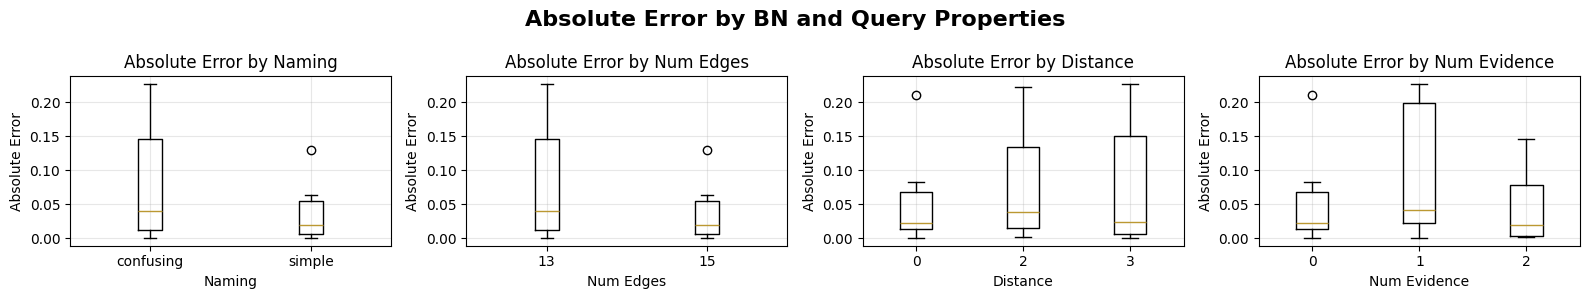


Summary Statistics by Property:

NAMING:
           count      mean       std       min       max
naming                                                  
confusing     21  0.077346  0.084162  0.000003  0.227203
simple         8  0.036313  0.044540  0.000012  0.130332

NUM_EDGES:
           count      mean       std       min       max
num_edges                                               
13            21  0.077346  0.084162  0.000003  0.227203
15             8  0.036313  0.044540  0.000012  0.130332

DISTANCE:
          count      mean       std       min       max
distance                                               
0            11  0.050073  0.060452  0.000012  0.210764
2            12   0.07474  0.081074  0.001242  0.222219
3             6  0.077849  0.101890  0.000003  0.227203

NUM_EVIDENCE:
              count      mean       std       min       max
num_evidence                                               
0                11  0.050073  0.060452  0.000012  0.210764
1   

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Filter to only successful LLM responses with exact inference results
plot_df = full_df[full_df['llm_probability'].notna() & full_df['probability'].notna()].copy()
plot_df['abs_error'] = abs(plot_df['llm_probability'] - plot_df['probability'])

if len(plot_df) > 0:
    # Identify all BN and query property columns (exclude result columns)
    exclude_cols = {'bn_index', 'query_vars', 'query_states', 'evidence', 'probability', 
                   'llm_probability', 'llm_response', 'abs_error', 'rel_error', 'target_tw', 'n', 'seed', 'variant_index',
                   'alpha', 'determinism', 'arity', 'query_index', 
                   'achieved_tw', 'num_nodes'}
    
    # Get all columns that are BN or query properties
    property_cols = [col for col in full_df.columns if col not in exclude_cols]
    
    # Calculate number of subplots needed
    n_props = len(property_cols)
    n_cols = min(4, n_props)  # Max 4 columns
    n_rows = (n_props + n_cols - 1) // n_cols  # Ceiling division
    
    # Create figure with subplots for all properties
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
    fig.suptitle('Absolute Error by BN and Query Properties', fontsize=16, fontweight='bold')
    
    # Flatten axes for easier indexing
    if n_props == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes.flatten()
    else:
        axes = axes.flatten()
    
    # Create boxplots for each property
    for i, prop in enumerate(property_cols):
        ax = axes[i]
        
        # Get unique values for this property
        unique_vals = sorted(plot_df[prop].unique())
        
        # Create boxplot data
        box_data = []
        labels = []
        
        for val in unique_vals:
            subset = plot_df[plot_df[prop] == val]['abs_error']
            if len(subset) > 0:  # Only include if there's data
                box_data.append(subset.values)
                labels.append(str(val))
        
        if box_data:  # Only plot if we have data
            ax.boxplot(box_data, labels=labels)
            ax.set_title(f'Absolute Error by {prop.replace("_", " ").title()}')
            ax.set_xlabel(prop.replace("_", " ").title())
            ax.set_ylabel('Absolute Error')
            ax.grid(True, alpha=0.3)
            
            # Rotate x-axis labels if there are many unique values
            if len(labels) > 5:
                ax.tick_params(axis='x', rotation=45)
    
    # Hide unused subplots
    for i in range(n_props, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics for each property
    print("\nSummary Statistics by Property:")
    print("=" * 50)
    
    for prop in property_cols:
        print(f"\n{prop.upper()}:")
        prop_stats = plot_df.groupby(prop)['abs_error'].agg(['count', 'mean', 'std', 'min', 'max'])
        print(prop_stats.round(6))
        
else:
    print("No successful LLM responses with exact inference results available for plotting.")
